In [47]:
from utils.definitions import *

import scipy.stats as stats

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from lightgbm import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error
from utils.scoring import weighted_cross_val_score
from utils.validation import TimeSeriesSplitGroups

# Feature engineering 👨‍🔧

In [48]:
train_df_augmented = train_df.copy()
test_df_augmented = test_df.copy()

- Add features to capture past performance.  

In [49]:
iqr = lambda x: stats.iqr(x, nan_policy="omit")

# Train data
train_df_augmented["Ret_Sum_Intraday"] = train_df[intra_ret_feat_cols].sum(axis=1)
train_df_augmented["Ret_Std_Intraday"] = train_df[intra_ret_feat_cols].std(axis=1)
train_df_augmented["Ret_Med_Intraday"] = train_df[intra_ret_feat_cols].median(axis=1)
train_df_augmented["Ret_Mean_Intraday"] = train_df[intra_ret_feat_cols].mean(axis=1)
train_df_augmented["Ret_IQR_Intraday"] = train_df[intra_ret_feat_cols].apply(iqr, axis=1)
train_df_augmented["Ret_Std_Daily"] = train_df[inter_ret_feat_cols].std(axis=1)
train_df_augmented["Ret_Med_Daily"] = train_df[inter_ret_feat_cols].median(axis=1)
train_df_augmented["Ret_Mean_Daily"] = train_df[inter_ret_feat_cols].mean(axis=1)

# Test data
test_df_augmented["Ret_Sum_Intraday"] = test_df[intra_ret_feat_cols].sum(axis=1)
test_df_augmented["Ret_Std_Intraday"] = test_df[intra_ret_feat_cols].std(axis=1)
test_df_augmented["Ret_Med_Intraday"] = test_df[intra_ret_feat_cols].median(axis=1)
test_df_augmented["Ret_Mean_Intraday"] = test_df[intra_ret_feat_cols].mean(axis=1)
test_df_augmented["Ret_IQR_Intraday"] = test_df[intra_ret_feat_cols].apply(iqr, axis=1)
test_df_augmented["Ret_Std_Daily"] = test_df[inter_ret_feat_cols].std(axis=1)
test_df_augmented["Ret_Med_Daily"] = test_df[inter_ret_feat_cols].median(axis=1)
test_df_augmented["Ret_Mean_Daily"] = test_df[inter_ret_feat_cols].mean(axis=1)

In [50]:
num_features = [
    "Feature_2", "Feature_3", "Feature_4", "Feature_6", "Feature_11", 
    "Feature_14", "Feature_17", "Feature_18", "Feature_19", "Feature_21", 
    "Feature_22", "Feature_23", "Feature_24", "Feature_25", "Ret_MinusTwo", 
    "Ret_MinusOne", "Ret_Sum_Intraday", "Ret_Std_Intraday", "Ret_Med_Intraday", "Ret_Mean_Intraday", "Ret_IQR_Intraday", "Ret_Med_Daily", "Ret_Mean_Daily", 
    "Ret_Std_Daily",
]

cat_features_ordinal = ["Feature_13"]
cat_features_nominal = [
    "Feature_1", "Feature_5", "Feature_7", "Feature_8", "Feature_9", 
    "Feature_10", "Feature_12", "Feature_15", "Feature_16", "Feature_20"
]
cat_features = cat_features_ordinal + cat_features_nominal

- There is supposed to be some relationship between the features and the interday targets.
- But each observation has so much noise that my models can't capture this.
- Since observations are highly correlated within the groups, maybe the average of each feature  
over each group has a clearer relationship with the target. This idea comes from reasoning that   
the noise will average out over a large sample. 

[]

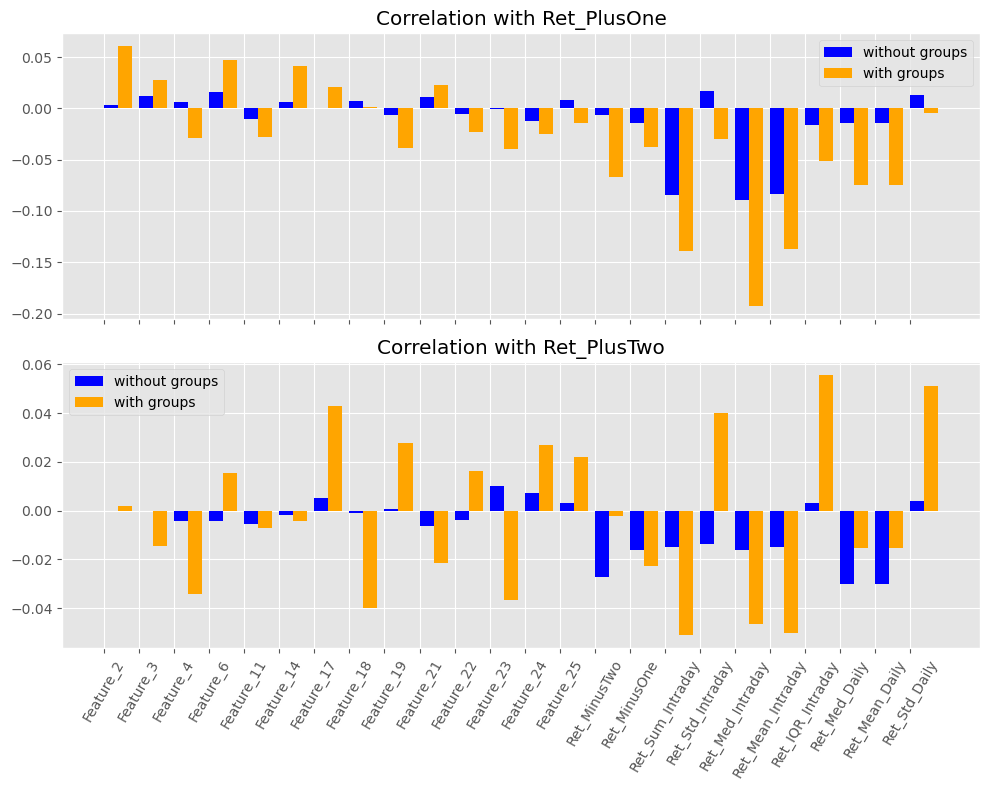

In [51]:
corr = (train_df_augmented[num_features + inter_ret_target_cols]
        .corr()[inter_ret_target_cols].iloc[:-2])
corr_groups = (train_df_augmented[num_features + inter_ret_target_cols].groupby(train_groups).mean()
               .corr()[inter_ret_target_cols]).iloc[:-2]

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot correlations of features with Ret_PlusOne
axes[0].bar(x=np.arange(corr.shape[0]), height=corr.Ret_PlusOne, 
            width=0.4, align="edge", color="blue")
axes[0].bar(x=np.arange(corr.shape[0]) + 0.4, height=corr_groups.Ret_PlusOne, 
            width=0.4, align="edge", color="orange")
axes[0].set_xticks(np.arange(corr.shape[0]), [""]*corr.shape[0])
axes[0].set_title("Correlation with Ret_PlusOne")
axes[0].legend(["without groups", "with groups"])

# Plot correlations of features with Ret_PlusTwo
axes[1].bar(x=np.arange(corr.shape[0]), height=corr.Ret_PlusTwo, 
            width=0.4, align="edge", color="blue")
axes[1].bar(x=np.arange(corr.shape[0]) + 0.4, height=corr_groups.Ret_PlusTwo, 
            width=0.4, align="edge", color="orange")
axes[1].set_xticks(np.arange(corr.shape[0]), corr.index, rotation=60)
axes[1].set_title("Correlation with Ret_PlusTwo")
axes[1].legend(["without groups", "with groups"])

plt.tight_layout()
plt.plot()

- Looks like my reasoning was correct.
- Now to create some features which capture this. 

In [52]:
mode = lambda x: stats.mode(x, nan_policy="omit").mode[0]

# Train data - Combine grouped statistics with the original train_df_augmented
train_df_augmented = train_df_augmented.merge(
    train_df_augmented[num_features].groupby(train_groups).agg("median").add_suffix("_grp_medians"),
    left_on="Feature_7",
    right_index=True,
    how="left"
)
train_df_augmented = train_df_augmented.merge(
    train_df_augmented[num_features].groupby(train_groups).agg("mean").add_suffix("_grp_means"),
    left_on="Feature_7",
    right_index=True,
    how="left"
)
train_df_augmented = train_df_augmented.merge(
    train_df_augmented[num_features].groupby(train_groups).agg(iqr).add_suffix("_grp_iqrs"),
    left_on="Feature_7",
    right_index=True,
    how="left"
)
train_df_augmented = train_df_augmented.merge(
    train_df_augmented[num_features].groupby(train_groups).agg("std").add_suffix("_grp_stds"),
    left_on="Feature_7",
    right_index=True,
    how="left"
)

# Test data - Combine grouped statistics with the original test_df_augmented
test_df_augmented = test_df_augmented.merge(
    test_df_augmented[num_features].groupby(test_groups).agg("median").add_suffix("_grp_medians"),
    left_on="Feature_7",
    right_index=True,
    how="left"
)
test_df_augmented = test_df_augmented.merge(
    test_df_augmented[num_features].groupby(test_groups).agg("mean").add_suffix("_grp_means"),
    left_on="Feature_7",
    right_index=True,
    how="left"
)
test_df_augmented = test_df_augmented.merge(
    test_df_augmented[num_features].groupby(test_groups).agg(iqr).add_suffix("_grp_iqrs"),
    left_on="Feature_7",
    right_index=True,
    how="left"
)
test_df_augmented = test_df_augmented.merge(
    test_df_augmented[num_features].groupby(test_groups).agg("std").add_suffix("_grp_stds"),
    left_on="Feature_7",
    right_index=True,
    how="left"
)

- Decided to only use these features obtained from grouping to avoid overfitting the noise. 

In [53]:
suffixes = ["_grp_medians", "_grp_means",  "_grp_iqrs", "_grp_stds"]
num_group_features = [feature + suffix for suffix in suffixes for feature in num_features]

cat_group_features_nominal = [feature + "_grp_modes" for feature in cat_features_nominal]
cat_group_features_ordinal = [feature + "_grp_modes" for feature in cat_features_ordinal]

num_features_final = num_group_features + num_features
cat_features_nominal_final = cat_features_nominal
cat_features_ordinal_final = cat_features_ordinal
cat_features_final = cat_features_nominal_final + cat_features_ordinal_final

features_final = num_features_final + cat_features_final

In [54]:
train_X_df = train_df_augmented[features_final]
test_X_df = test_df_augmented[features_final]

# Preprocessing ⚙️

In [55]:
# Preprocessing for nominal categorical data
cat_transformer_nominal = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant")),
    ("pca", PCA(whiten=True, random_state=0)),
    ("bins", KBinsDiscretizer(n_bins=100, encode="onehot", strategy="quantile")),
])

# Preprocessing for ordinal categorical data
cat_transformer_ordinal = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant")),
    ("bins", KBinsDiscretizer(n_bins=100, encode="ordinal", strategy="quantile")),
])

# Combined preprocessing for numerical and categorical data
preprocessor_X = ColumnTransformer(transformers=[       
    ("cat_nom", cat_transformer_nominal, cat_features_nominal_final),
    ("cat_ord", cat_transformer_ordinal, cat_features_ordinal_final),        
], remainder="passthrough")

# Target transformer
preprocessor_Y = Pipeline(steps=[
    ("quantile", QuantileTransformer(n_quantiles=300, output_distribution="normal", 
                                     random_state=0)),
])

# The model 💃

- Small learning rate to prevent overfitting.

In [56]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_X), 
    ("model", LGBMRegressor(learning_rate=0.001, random_state=0))
])
estimator = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=preprocessor_Y
)

# Testing 🧪

### Ret_PlusOne

In [57]:
scores = weighted_cross_val_score(
    DummyRegressor(strategy="median"),
    X=train_X_df, y=train_df.Ret_PlusOne,
    weights=weight_interday,
    groups=train_groups,
    cv=TimeSeriesSplitGroups(n_splits=10),
    scoring=mean_absolute_error
)

print("Mean", np.mean(scores))
print("STD", np.std(scores))
print("Median: ", np.median(scores))
print("IQR", stats.iqr(scores))

Mean 0.015174921830208219
STD 0.000678830665627906
Median:  0.015259620841189989
IQR 0.0007137630739527234


In [58]:
scores = weighted_cross_val_score(
    estimator,
    X=train_X_df, y=train_df.Ret_PlusOne,
    weights=weight_interday,
    groups=train_groups,
    cv=TimeSeriesSplitGroups(n_splits=10),
    scoring=mean_absolute_error,
)

print("Mean", np.mean(scores))
print("STD", np.std(scores))
print("Median: ", np.median(scores))
print("IQR", stats.iqr(scores))

Mean 0.01516456130390818
STD 0.0007018020184071264
Median:  0.015225089615219753
IQR 0.0007677366019810568


### Ret_PlusTwo

In [59]:
scores = weighted_cross_val_score(
    DummyRegressor(strategy="median"),
    X=train_X_df, y=train_df.Ret_PlusTwo,
    weights=weight_interday,
    groups=train_groups,
    cv=TimeSeriesSplitGroups(n_splits=10),
    scoring=mean_absolute_error
)

print("Mean", np.mean(scores))
print("STD", np.std(scores))
print("Median: ", np.median(scores))
print("IQR", stats.iqr(scores))

Mean 0.014778421844621959
STD 0.0011354004209824518
Median:  0.014778449754856208
IQR 0.0016224712671204927


In [60]:
scores = weighted_cross_val_score(
    estimator,
    X=train_X_df, y=train_df.Ret_PlusTwo,
    weights=weight_interday,
    groups=train_groups,
    cv=TimeSeriesSplitGroups(n_splits=10),
    scoring=mean_absolute_error,
)

print("Mean", np.mean(scores))
print("STD", np.std(scores))
print("Median: ", np.median(scores))
print("IQR", stats.iqr(scores))

Mean 0.014777952913864651
STD 0.001125056214818917
Median:  0.014757370272873879
IQR 0.0015496006863918027


# Predictions 💫

- Filter outliers to reduce overfitting.

In [61]:
y_test_pred = pd.DataFrame(columns=inter_ret_target_cols)

In [62]:
for col_name in y_test_pred:
    y_train = train_df[col_name]

    # Filter outliers
    y_trans = preprocessor_Y.fit_transform(y_train.values.reshape(-1, 1)).reshape(-1) 
    mask = ~np.logical_or(y_trans < -3, 3 < y_trans) # transformed y with sd <= 3
  
    estimator.fit(train_X_df[mask], y_train[mask], model__sample_weight=weight_interday[mask])
    test_y_col_pred = estimator.predict(test_X_df)

    y_test_pred[col_name] = test_y_col_pred

In [63]:
submission = pd.read_csv("data/raw/sample_submission_2.csv", index_col=0)
submission.iloc[np.arange(60, submission.size, 62)] = y_test_pred.Ret_PlusOne.values.reshape(-1, 1)
submission.iloc[np.arange(61, submission.size, 62)] = y_test_pred.Ret_PlusTwo.values.reshape(-1, 1)
submission.to_csv("data/submissions/submission.csv")

- Score: 1728.55275
- Second place
- Top 0.2 %